In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np

In [2]:
from min_bisection import solution_schema

In [3]:
fldr = 'runs\\random'

In [38]:
meta_dfs = []
run_dfs = []
sub_fldrs = [x[0] for x in os.walk(fldr)]
for sub_fldr in sub_fldrs[1:]:
    print(sub_fldr)
    meta_dfs.append(pd.read_csv(os.path.join(sub_fldr, 'summary_stats.csv')))
    run_dfs.append(pd.read_csv(os.path.join(sub_fldr, 'run_stats.csv')))
meta = pd.concat(meta_dfs)
run = pd.concat(run_dfs)

runs\random\random_10
runs\random\random_20
runs\random\random_30
runs\random\random_40
runs\random\random_50


In [39]:
meta

,solve_id,solve_type,method,warm_start,n,p,q,cut_type,cut_value,min_order,min_proportion,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,once,auto,cold,10,0.5,0.1,fixed,10,0,1.0,45,481,0.044406,0.006910,0.037496,4.75
1,0,iterative,dual,warm,10,0.5,0.1,fixed,10,0,0.1,45,173,0.082811,0.005538,0.077273,4.75
2,1,once,auto,cold,10,0.5,0.1,fixed,10,1,1.0,45,481,0.027626,0.003362,0.024264,1.00
3,1,iterative,dual,warm,10,0.5,0.1,fixed,10,1,1.0,45,111,0.025361,0.001326,0.024034,1.00
4,2,once,auto,cold,10,0.5,0.1,fixed,30,0,1.0,45,481,0.032920,0.004070,0.028850,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,377,iterative,dual,warm,50,0.8,0.2,fixed,3000,0,0.1,1225,3101,3.809703,0.049800,3.759902,121.00
756,378,once,auto,cold,50,0.8,0.2,fixed,3000,1,1.0,1225,78401,20.393435,17.112023,3.281411,109.00
757,378,iterative,dual,warm,50,0.8,0.2,fixed,3000,1,1.0,1225,3376,4.980619,0.201276,4.779343,109.00
758,379,once,auto,cold,50,0.8,0.2,fixed,10000,0,1.0,1225,78401,22.919524,19.628070,3.291454,116.00


In [40]:
run

,solve_id,solve_type,method,warm_start,sub_solve_id,n,p,q,cut_type,cut_value,cuts_sought,cuts_added,min_order,min_proportion,proportion_used,variables,constraints,cpu_time
0,0,once,auto,cold,0,10,0.5,0.1,fixed,10,480,480,0,1.0,1.0,45,481,0.006910
1,0,iterative,dual,warm,0,10,0.5,0.1,fixed,10,100,100,0,0.1,1.0,45,101,0.001277
2,0,iterative,dual,warm,1,10,0.5,0.1,fixed,10,10,0,0,0.1,1.0,45,111,0.000781
3,0,iterative,dual,warm,2,10,0.5,0.1,fixed,10,10,0,0,0.1,1.0,45,121,0.000760
4,0,iterative,dual,warm,3,10,0.5,0.1,fixed,10,10,0,0,0.1,1.0,45,131,0.000628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102471,379,iterative,dual,warm,0,50,0.8,0.2,fixed,10000,100,100,0,1.0,1.0,1225,101,0.004852
102472,379,iterative,dual,warm,1,50,0.8,0.2,fixed,10000,10000,0,0,1.0,1.0,1225,7859,0.787764
102473,379,iterative,dual,warm,2,50,0.8,0.2,fixed,10000,10000,0,0,1.0,1.0,1225,16048,0.043833
102474,379,iterative,dual,warm,3,50,0.8,0.2,fixed,10000,10000,0,0,1.0,1.0,1225,26048,0.033413


In [33]:
def cpu_time_graph(time_measure, ignored_pairs, line_style):
    col_selection = time_measure if time_measure != 'proportion_cpu_time_gurobi' else ['total_cpu_time', 'gurobi_cpu_time']
    # average the runs
    gd = meta.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_proportion', 'n'])[col_selection].mean().reset_index()

    # get once solves down to single data points - don't need multiple for cut_values - recasts cut_value as nan
    once = gd[gd['solve_type'] == 'once']
    once = once.groupby(['p', 'q', 'solve_type', 'min_proportion', 'n'])[col_selection].mean().reset_index()
    once['cut_value'] = 'single'
    once['min_proportion'] = 'solve'
    gd = pd.concat([gd[gd['solve_type'] != 'once'], once])
    gd['idx'] = gd['cut_value'].astype(str) + '_' + gd['min_proportion'].astype(str)

    # filter graph data by data set
    filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

    # graph for each p, q combination 
    for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
        for name, fltr in filters.items():
            if name in ignored_pairs:
                continue
            subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
            style = line_style.get(name.partition('_')[0], '-')
            if isinstance(col_selection, list):
                plt.plot(subset['n'], subset[col_selection[1]]/subset[col_selection[0]], linestyle=style, label=name)
            else:
                plt.plot(subset['n'], subset[col_selection], linestyle=style, label=name)

        plt.title(f'{time_measure} comparison for p={p}, q={q}')
        plt.ylabel('proportion_of_cpu_time')
        plt.xlabel('n')
        plt.legend()
        plt.show()

## Total CPU Time

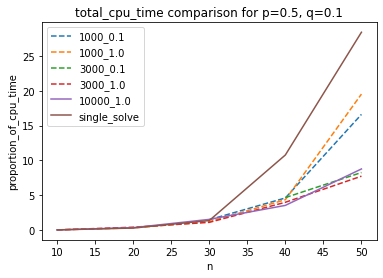

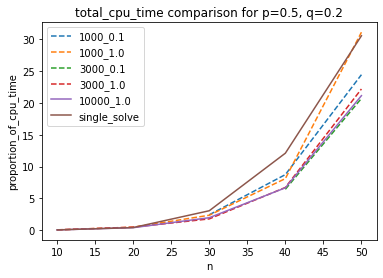

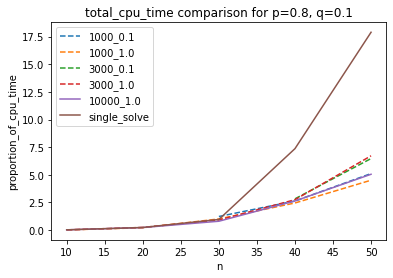

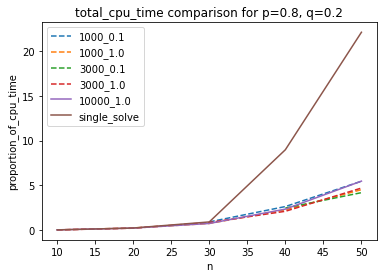

In [34]:
time_measure = 'total_cpu_time'
ignored_pairs = ['10_1.0', '10_0.1', '10_0.01', '10_0.001', '30_1.0', '30_0.1', '30_0.01', '30_0.001',
                 '100_1.0', '100_0.1', '100_0.01', '300_1.0', '300_0.1', '300_0.01',]
line_style = {
    '10': ':',
    '30': ':',
    '100': '-.',
    '300': '-.',
    '1000': '--',
    '3000': '--',
}

cpu_time_graph(time_measure, ignored_pairs, line_style)

## Gurobi CPU Time

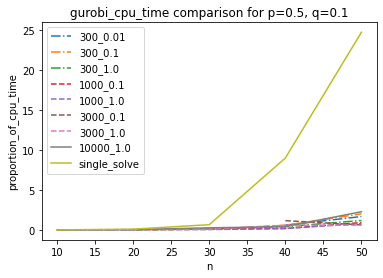

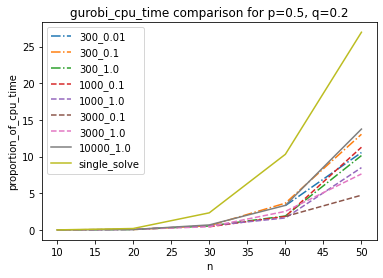

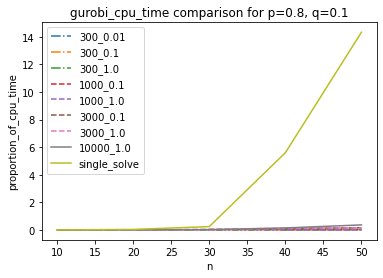

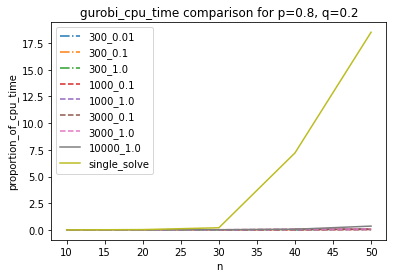

In [36]:
time_measure = 'gurobi_cpu_time'
ignored_pairs = ['10_1.0', '10_0.1', '10_0.01', '10_0.001', '30_1.0', '30_0.1', '30_0.01', '30_0.001',
                '100_1.0', '100_0.1', '100_0.01']
line_style = {
    '10': ':',
    '30': ':',
    '100': '-.',
    '300': '-.',
    '1000': '--',
    '3000': '--',
}

cpu_time_graph(time_measure, ignored_pairs, line_style)

## Proportion CPU Time Gurobi

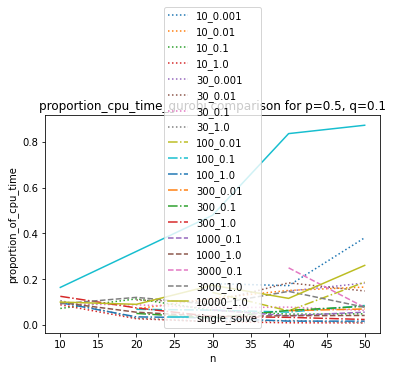

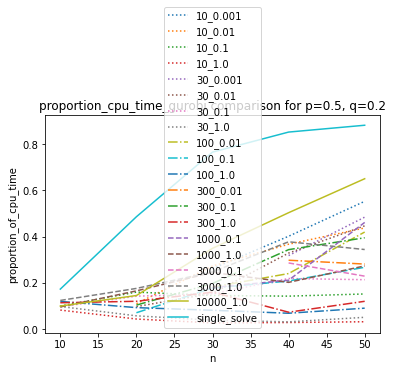

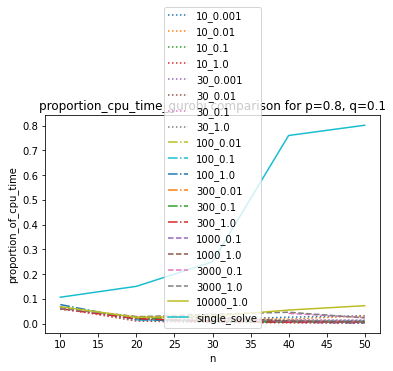

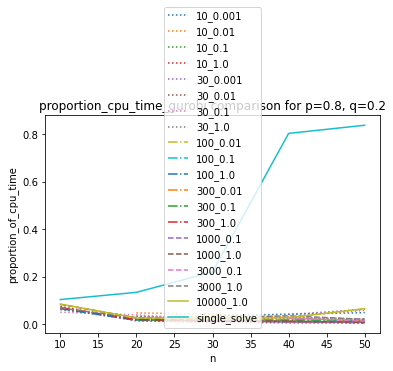

In [37]:
time_measure = 'proportion_cpu_time_gurobi'
ignored_pairs = []
line_style = {
    '10': ':',
    '30': ':',
    '100': '-.',
    '300': '-.',
    '1000': '--',
    '3000': '--',
}

cpu_time_graph(time_measure, ignored_pairs, line_style)

## Number of LP's per Solve

In [41]:
run.head()

,solve_id,solve_type,method,warm_start,sub_solve_id,n,p,q,cut_type,cut_value,cuts_sought,cuts_added,min_order,min_proportion,proportion_used,variables,constraints,cpu_time
0,0,once,auto,cold,0,10,0.5,0.1,fixed,10,480,480,0,1.0,1.0,45,481,0.006910
1,0,iterative,dual,warm,0,10,0.5,0.1,fixed,10,100,100,0,0.1,1.0,45,101,0.001277
2,0,iterative,dual,warm,1,10,0.5,0.1,fixed,10,10,0,0,0.1,1.0,45,111,0.000781
3,0,iterative,dual,warm,2,10,0.5,0.1,fixed,10,10,0,0,0.1,1.0,45,121,0.000760
4,0,iterative,dual,warm,3,10,0.5,0.1,fixed,10,10,0,0,0.1,1.0,45,131,0.000628


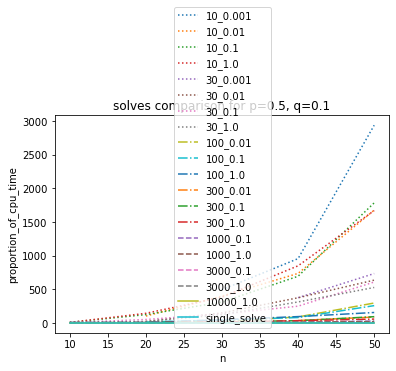

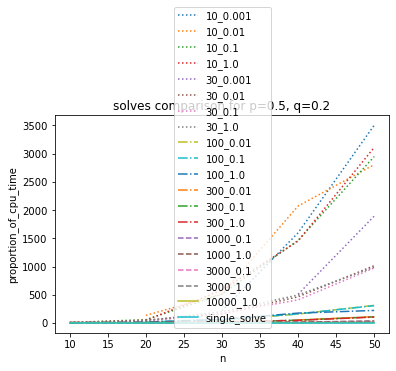

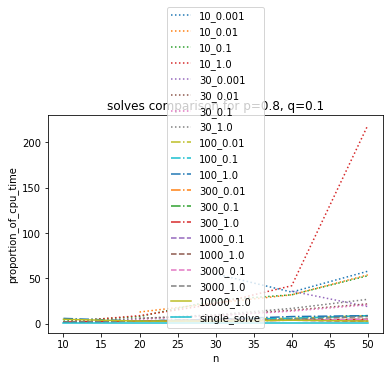

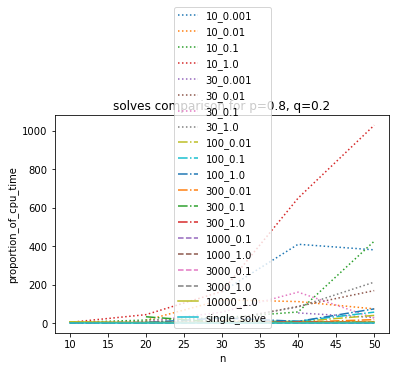

In [45]:
ignored_pairs = []
line_style = {
    '10': ':',
    '30': ':',
    '100': '-.',
    '300': '-.',
    '1000': '--',
    '3000': '--',
}

# average the runs
gd = run.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_proportion', 'n'])['sub_solve_id'].max().reset_index()

# get once solves down to single data points - don't need multiple for cut_values - recasts cut_value as nan
once = gd[gd['solve_type'] == 'once']
once = once.groupby(['p', 'q', 'solve_type', 'min_proportion', 'n'])['sub_solve_id'].max().reset_index()
once['cut_value'] = 'single'
once['min_proportion'] = 'solve'

# merge back and reformat df
gd = pd.concat([gd[gd['solve_type'] != 'once'], once])
gd['idx'] = gd['cut_value'].astype(str) + '_' + gd['min_proportion'].astype(str)
gd.rename(columns={'sub_solve_id': 'solves'}, inplace=True)
gd['solves'] += 1

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        if name in ignored_pairs:
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
        style = line_style.get(name.partition('_')[0], '-')
        plt.plot(subset['n'], subset['solves'], linestyle=style, label=name)

    plt.title(f'solves comparison for p={p}, q={q}')
    plt.ylabel('proportion_of_cpu_time')
    plt.xlabel('n')
    plt.legend()
    plt.show()